In [5]:
import numpy as np
import math
from scipy.optimize import linear_sum_assignment

# Calculation of location similarity LocSim
def loc_sim(P_pos, G_pos, tau):
    """
    Function to compute location similarity LocSim
    
    \[
    \operatorname{LocSim}(P, G) = \exp\!\left( \ln(0.05) \cdot \frac{\|P - G\|_2^2}{\tau^2} \right)
    \]
    
    :param P_pos: Predicted position (coordinates in list or numpy array)
    :param G_pos: Ground Truth Location
    :param tau: normalized parameter
    :return: LocSim Value
    """
    P_pos = np.array(P_pos)
    G_pos = np.array(G_pos)
    distance_sq = np.sum((P_pos - G_pos)**2)
    sim = math.exp(math.log(0.05) * (distance_sq / (tau**2)))
    return sim

# Calculation of attribute similarity IdSim
def id_sim(P_attr, G_attr):
    """
    Function to calculate attribute similarity IdSim
    \[
    \operatorname{IdSim}(P, G) =
    \begin{cases}
    1, & \text{if } P_{\text{attr}} = G_{\text{attr}}, \\
    0, & \text{otherwise.}
    \end{cases}
    \]
    :param P_attr: Attributes of prediction (specify each attribute in a dictionary, etc.)
    :param G_attr: Ground Truth Attributes
    :return: 1 if all attributes match, 0 otherwise
    """

    return 1

# Overall similarity of each pair
def sim_ti_hota(P, G, tau):
    """
    Function to calculate the overall similarity of TI-HOTA
    \[
    \operatorname{Sim}_{\mathrm{TI\text{-}HOTA}}(P, G) = \operatorname{LocSim}(P, G) \times \operatorname{IdSim}(P, G)
    \]
    :param P: Prediction Information {'position': [x, y, ...], 'attributes': {...}} 
    :param G: Ground Truth Information {'position': [x, y, ...], 'attributes': {...}} 
    :param tau: normalized parameter for loc_sim calculation
    :return: overall similarity Sim_{TI-HOTA}
    """
    
    return loc_sim(P['position'], G['position'], tau) * id_sim(P['attributes'], G['attributes'])

def compute_ti_hota_alpha(frames, tau, alpha):
    total_tp = total_fp = total_fn = 0
    assoc_counts = {}
    fpa_counts = {}

    for frame in frames:
        gt_objs = frame.get('ground_truths', [])
        pred_objs = frame.get('predictions', [])
        n_gt, n_pred = len(gt_objs), len(pred_objs)
        
        # Build similarity and cost matrices
        combined = np.zeros((n_gt, n_pred))
        cost = np.zeros((n_gt, n_pred))
        for i, gt in enumerate(gt_objs):
            for j, pred in enumerate(pred_objs):
                loc = loc_sim(pred['position'], gt['position'], tau)
                combined[i, j] = loc * id_sim(pred['attributes'], gt['attributes'])
                cost[i, j] = 1 - combined[i, j]

        # Exclude below-threshold pairs
        cost[combined < alpha] = 1e6
        row_ind, col_ind = linear_sum_assignment(cost)

        # Determine current valid matches
        curr_gt_match = {}
        for i, j in zip(row_ind, col_ind):
            if combined[i, j] >= alpha:
                curr_gt_match[i] = j

        # Update detection counts
        tp = len(curr_gt_match)
        fp = n_pred - tp
        fn = n_gt   - tp
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Association counts (for AssA calculation)
        matched_gt = set(curr_gt_match.keys())
        for i, gt in enumerate(gt_objs):
            gid = gt['attributes']
            assoc_counts.setdefault(gid, {'TPA': 0, 'FNA': 0})
            if i not in matched_gt:
                assoc_counts[gid]['FNA'] += 1
        for i, j in curr_gt_match.items():
            gid = gt_objs[i]['attributes']
            assoc_counts[gid]['TPA'] += 1
        for j, pred in enumerate(pred_objs):
            if j not in curr_gt_match.values():
                pid = pred['attributes']
                fpa_counts[pid] = fpa_counts.get(pid, 0) + 1

    # Compute average DetA and AssA
    total_det = total_tp + total_fp + total_fn
    det_acc = total_tp / total_det if total_det > 0 else 0
    sum_A = n_tracks = 0
    for gid, cnt in assoc_counts.items():
        denom = cnt['TPA'] + cnt['FNA'] + fpa_counts.get(gid, 0)
        if denom > 0:
            sum_A += cnt['TPA'] / denom
            n_tracks += 1
    ass_acc = sum_A / n_tracks if n_tracks > 0 else 0

    # TI-HOTA for this alpha
    ti_hota_alpha = math.sqrt(det_acc * ass_acc)
    
    return ti_hota_alpha, det_acc, ass_acc, total_tp, total_fp, total_fn

# The function that calculates TI-HOTA for each threshold value α and takes the mean of the TI-HOTA_α
def compute_ti_hota(frames, tau):
    alphas = np.arange(0.05, 1.0, 0.05)
    ti_hota_alphas = []
    det_acc_values = []
    ass_acc_values = []
    total_tp_values = []
    total_fp_values = []
    total_fn_values = []
    
    for alpha in alphas:
        ti_hota_alpha, det_acc, ass_acc, tp, fp, fn = compute_ti_hota_alpha(frames, tau, alpha)
        ti_hota_alphas.append(ti_hota_alpha)
        det_acc_values.append(det_acc)
        ass_acc_values.append(ass_acc)
        total_tp_values.append(tp)
        total_fp_values.append(fp)
        total_fn_values.append(fn)
        
    ti_hota = np.mean(ti_hota_alphas)
    mean_det_acc = np.mean(det_acc_values)
    mean_ass_acc = np.mean(ass_acc_values)
    mean_total_tp = np.mean(total_tp_values)
    mean_total_fp = np.mean(total_fp_values)
    mean_total_fn = np.mean(total_fn_values)
    
    metrics = {
        "TI-HOTA": ti_hota,
        "TI-HOTA_alphas": ti_hota_alphas,
        "TI-DetA": mean_det_acc,
        "TI-AssA": mean_ass_acc,
        "TI-TP": mean_total_tp,
        "TI-FP": mean_total_fp,
        "TI-FN": mean_total_fn,
    }
    return metrics, alphas

In [6]:
# Function to read txt files of round truth and prediction results and group them by frames
def load_frames(file_path):
    frames_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 5:
                continue
            # Row contents: frame, ID, x, y, attribute
            frame = int(parts[0])
            id = int(parts[1])
            x = float(parts[2])
            y = float(parts[3])
            attributes = parts[4]
            obj = {'position': [x, y], 'id': id, 'attributes': attributes}
            if frame not in frames_dict:
                frames_dict[frame] = []
            frames_dict[frame].append(obj)
    return frames_dict

# Reads the ground truth file of the same name and the prediction result file and merges them frame by frame
def load_video(gt_file, pred_file):
    gt_frames = load_frames(gt_file)
    pred_frames = load_frames(pred_file)
    all_frame_ids = sorted(set(gt_frames.keys()) | set(pred_frames.keys()))
    frames = []
    for frame_id in all_frame_ids:
        frame_data = {
            'ground_truths': gt_frames.get(frame_id, []),
            'predictions': pred_frames.get(frame_id, [])
        }
        frames.append(frame_data)
    return frames

In [18]:
import os
import glob
import numpy as np

# --- Indoor Settings ---
gt_folder = '../ground_truth/Indoor/transformed_MOT_with_attributes'
pred_folder = '../output/CAMELTrack_outputs/Indoor/filtered_MOT/'
tau = 100

# List of txt files in ground truth folder
gt_files = glob.glob(os.path.join(gt_folder, '*.txt'))

baseline_results = {}    

# List to store evaluation results and number of frames for each video
indoor_results = []   # Stores metrics (dictionary) for each video
indoor_frame_counts = []  # Number of frames for each video

for gt_file in gt_files:
    filename = os.path.basename(gt_file)
    pred_file = os.path.join(pred_folder, filename)
    if not os.path.exists(pred_file):
        print(f"Pred result file {pred_file} not found.Skip.")
        continue

    frames = load_video(gt_file, pred_file)
    num_frames = len(frames)
    indoor_frame_counts.append(num_frames)
    
    metrics, alphas = compute_ti_hota(frames, tau)
    indoor_results.append(metrics)

    baseline_results[filename] = metrics

    print(f"Video: {filename}")
    print(f"  Number of frames: {num_frames}")
    print(f"  TI-HOTA: {metrics['TI-HOTA']:.4f}")
    print(f"  TI-DetA: {metrics['TI-DetA']:.4f}")
    print(f"  TI-AssA: {metrics['TI-AssA']:.4f}")
    print(f"  TI-TP: {metrics['TI-TP']:.2f}, TI-FP: {metrics['TI-FP']:.2f}, TI-FN: {metrics['TI-FN']:.2f}")
    print("-" * 50)

# Organized into a list by evaluation metrics
keys = ["TI-HOTA", "TI-DetA", "TI-AssA", "TI-TP", "TI-FP", "TI-FN"]
metrics_data = { key: [] for key in keys }
for m in indoor_results:
    for key in keys:
        metrics_data[key].append(m[key])

print(f"===== Indoor Videos: Mean ± SD (τ={tau}) =====")
if indoor_frame_counts:
    frame_avg = np.mean(indoor_frame_counts)
    frame_std = np.std(indoor_frame_counts)
    print(f"Frame Count: {frame_avg:.2f} (std: {frame_std:.2f})")
    
for key in keys:
    if metrics_data[key]:
        avg = np.mean(metrics_data[key])
        std = np.std(metrics_data[key])
        print(f"{key}: {avg:.4f} (std: {std:.4f})")
    else:
        print(f"{key}: No data")


Video: basket_S3T6_pre.txt
  Number of frames: 196
  TI-HOTA: 0.0252
  TI-DetA: 0.0181
  TI-AssA: 0.0353
  TI-TP: 41.47, TI-FP: 1134.53, TI-FN: 1134.53
--------------------------------------------------
Video: basket_S4T2_post.txt
  Number of frames: 240
  TI-HOTA: 0.0100
  TI-DetA: 0.0071
  TI-AssA: 0.0141
  TI-TP: 20.32, TI-FP: 1419.68, TI-FN: 1419.68
--------------------------------------------------
Video: basket_S4T3_post.txt
  Number of frames: 34
  TI-HOTA: 0.0369
  TI-DetA: 0.0269
  TI-AssA: 0.0506
  TI-TP: 10.32, TI-FP: 193.68, TI-FN: 193.68
--------------------------------------------------
Video: basket_S1T1_pre.txt
  Number of frames: 168
  TI-HOTA: 0.0066
  TI-DetA: 0.0047
  TI-AssA: 0.0093
  TI-TP: 9.37, TI-FP: 998.63, TI-FN: 998.63
--------------------------------------------------
Video: basket_S2T5_pre.txt
  Number of frames: 184
  TI-HOTA: 0.0160
  TI-DetA: 0.0115
  TI-AssA: 0.0224
  TI-TP: 24.74, TI-FP: 1079.26, TI-FN: 1079.26
----------------------------------------

In [8]:
print("Outdoor TI-HOTA evaluation skipped: only Indoor is evaluated in this notebook.")

Outdoor TI-HOTA evaluation skipped: only Indoor is evaluated in this notebook.


In [19]:
import os
import glob
import numpy as np

# --- Indoor Settings: OURS (smoothed & cleaned tracks) ---
gt_folder = '../ground_truth/Indoor/transformed_MOT_with_attributes'
pred_folder = '../output/CAMELTrack_outputs/Indoor/filtered_MOT_smooth/'
tau = 100

gt_files = glob.glob(os.path.join(gt_folder, '*.txt'))

ours_results = {}       
ours_metrics = []     
ours_frame_counts = []

for gt_file in gt_files:
    filename = os.path.basename(gt_file)
    pred_file = os.path.join(pred_folder, filename)
    if not os.path.exists(pred_file):
        print(f"[OURS] Pred result file {pred_file} not found. Skip.")
        continue

    frames = load_video(gt_file, pred_file)
    num_frames = len(frames)
    ours_frame_counts.append(num_frames)

    metrics, alphas = compute_ti_hota(frames, tau)
    ours_results[filename] = metrics
    ours_metrics.append(metrics)      

    print(f"[OURS] Video: {filename}")
    print(f"  Number of frames: {num_frames}")
    print(f"  TI-HOTA: {metrics['TI-HOTA']:.4f}")
    print(f"  TI-DetA: {metrics['TI-DetA']:.4f}")
    print(f"  TI-AssA: {metrics['TI-AssA']:.4f}")
    print(f"  TI-TP: {metrics['TI-TP']:.2f}, TI-FP: {metrics['TI-FP']:.2f}, TI-FN: {metrics['TI-FN']:.2f}")
    print("-" * 50)

# 汇总 OURS 的平均+标准差
keys = ["TI-HOTA", "TI-DetA", "TI-AssA", "TI-TP", "TI-FP", "TI-FN"]
metrics_data_ours = { key: [] for key in keys }
for m in ours_metrics:
    for key in keys:
        metrics_data_ours[key].append(m[key])

print(f"===== Indoor Videos (OURS, τ={tau}) : Mean ± SD =====")
if ours_frame_counts:
    frame_avg = np.mean(ours_frame_counts)
    frame_std = np.std(ours_frame_counts)
    print(f"Frame Count: {frame_avg:.2f} (std: {frame_std:.2f})")

for key in keys:
    if metrics_data_ours[key]:
        avg = np.mean(metrics_data_ours[key])
        std = np.std(metrics_data_ours[key])
        print(f"{key}: {avg:.4f} (std: {std:.4f})")
    else:
        print(f"{key}: No data")


[OURS] Video: basket_S3T6_pre.txt
  Number of frames: 196
  TI-HOTA: 0.0253
  TI-DetA: 0.0181
  TI-AssA: 0.0354
  TI-TP: 41.63, TI-FP: 1134.37, TI-FN: 1134.37
--------------------------------------------------
[OURS] Video: basket_S4T2_post.txt
  Number of frames: 240
  TI-HOTA: 0.0101
  TI-DetA: 0.0072
  TI-AssA: 0.0141
  TI-TP: 20.37, TI-FP: 1419.63, TI-FN: 1419.63
--------------------------------------------------
[OURS] Video: basket_S4T3_post.txt
  Number of frames: 34
  TI-HOTA: 0.0372
  TI-DetA: 0.0271
  TI-AssA: 0.0511
  TI-TP: 10.42, TI-FP: 193.58, TI-FN: 193.58
--------------------------------------------------
[OURS] Video: basket_S1T1_pre.txt
  Number of frames: 168
  TI-HOTA: 0.0066
  TI-DetA: 0.0047
  TI-AssA: 0.0092
  TI-TP: 9.32, TI-FP: 998.68, TI-FN: 998.68
--------------------------------------------------
[OURS] Video: basket_S2T5_pre.txt
  Number of frames: 184
  TI-HOTA: 0.0161
  TI-DetA: 0.0115
  TI-AssA: 0.0225
  TI-TP: 24.79, TI-FP: 1079.21, TI-FN: 1079.21
-----

In [25]:
import pandas as pd
import numpy as np

summary = {}

for key in keys:  # keys = ["TI-HOTA", "TI-DetA", "TI-AssA", "TI-TP", "TI-FP", "TI-FN"]
    base_vals = np.array(metrics_data[key])        if metrics_data[key]       else np.array([np.nan])
    ours_vals = np.array(metrics_data_ours[key])   if metrics_data_ours[key]  else np.array([np.nan])

    base_avg = np.nanmean(base_vals)
    ours_avg = np.nanmean(ours_vals)
    delta    = ours_avg - base_avg
    rel      = delta / base_avg if base_avg != 0 else np.nan

    summary[key] = {
        "Baseline": base_avg,
        "OURS": ours_avg,
        "Δ(OURS-Baseline)": delta,
        "Relative Δ": rel
    }

df_compare = pd.DataFrame(summary).T
df_compare


,Baseline,OURS,Δ(OURS-Baseline),Relative Δ
TI-HOTA,0.022567,0.022610,0.000043,0.001919
TI-DetA,0.016264,0.016297,0.000033,0.002007
TI-AssA,0.031317,0.031375,0.000057,0.001834
TI-TP,30.661654,30.686717,0.025063,0.000817
TI-FP,1045.624060,1045.598997,-0.025063,-0.000024
TI-FN,1045.624060,1045.598997,-0.025063,-0.000024


In [26]:
metrics_data       # baseline: key -> list of values per video
metrics_data_ours  # ours:     key -> list of values per video
keys = ["TI-HOTA", "TI-DetA", "TI-AssA"]


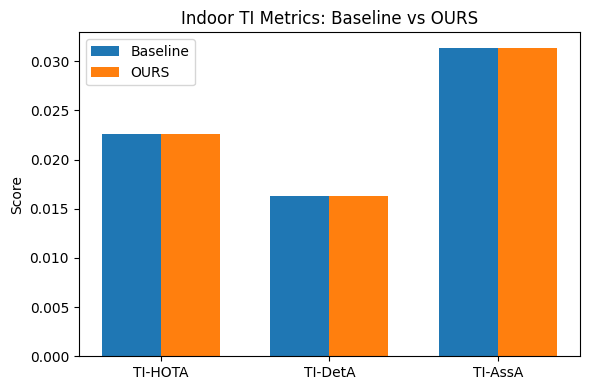

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 选几个最重要的指标
plot_keys = ["TI-HOTA", "TI-DetA", "TI-AssA"]

baseline_means = []
ours_means = []

for k in plot_keys:
    base_vals = np.array(metrics_data[k]) if metrics_data[k] else np.array([np.nan])
    ours_vals = np.array(metrics_data_ours[k]) if metrics_data_ours[k] else np.array([np.nan])
    baseline_means.append(np.nanmean(base_vals))
    ours_means.append(np.nanmean(ours_vals))

x = np.arange(len(plot_keys))  # x 轴位置
width = 0.35                   # 柱子宽度

fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x - width/2, baseline_means, width, label="Baseline")
ax.bar(x + width/2, ours_means,    width, label="OURS")

ax.set_xticks(x)
ax.set_xticklabels(plot_keys)
ax.set_ylabel("Score")
ax.set_title("Indoor TI Metrics: Baseline vs OURS")
ax.legend()
plt.tight_layout()
plt.show()


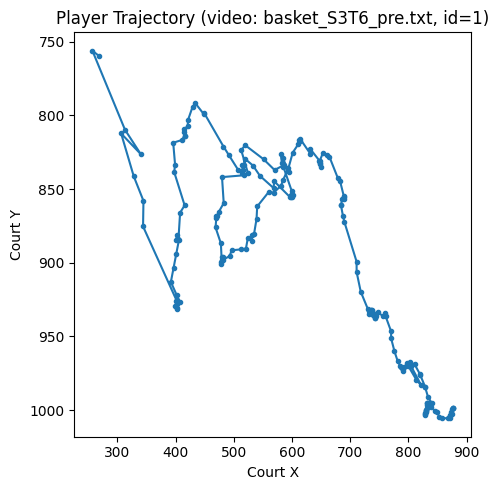

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 选一个样例视频
sample_file = "../output/CAMELTrack_outputs/Indoor/transformed/basket_S3T6_pre.txt"

if not os.path.exists(sample_file):
    print("File not found, please check the path.")
else:
    df = pd.read_csv(sample_file, header=None)
    # 假设格式: frame_id, id, court_x, court_y
    df.columns = ["frame_id", "id", "court_x", "court_y"]

    # 先选一个出现次数最多的球员 id
    main_id = df["id"].value_counts().idxmax()
    df_main = df[df["id"] == main_id].sort_values("frame_id")

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(df_main["court_x"], df_main["court_y"], marker=".", linestyle="-")

    ax.set_xlabel("Court X")
    ax.set_ylabel("Court Y")
    ax.set_title(f"Player Trajectory (video: {os.path.basename(sample_file)}, id={main_id})")
    ax.invert_yaxis()  # 有些坐标系需要翻转 y 轴，看着更像球场

    plt.tight_layout()
    plt.show()


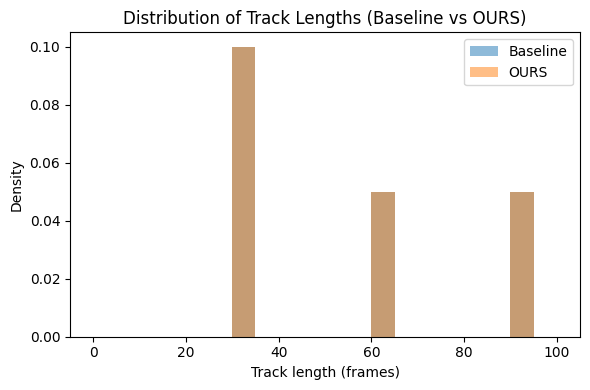

In [22]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def collect_track_lengths(folder):
    lengths = []
    files = glob.glob(os.path.join(folder, "*.txt"))
    for f in files:
        df = pd.read_csv(f, header=None)
        df.columns = ["frame_id", "id", "x", "y", "w", "h",
                      "conf", "cls", "vis", "empty"]
        # 每个 id 的轨迹长度（帧数）
        track_len = df.groupby("id")["frame_id"].nunique()
        lengths.extend(track_len.tolist())
    return np.array(lengths)

baseline_folder = "../output/CAMELTrack_outputs/Indoor/filtered_MOT"
ours_folder     = "../output/CAMELTrack_outputs/Indoor/filtered_MOT_smooth"

baseline_lengths = collect_track_lengths(baseline_folder)
ours_lengths     = collect_track_lengths(ours_folder)

fig, ax = plt.subplots(figsize=(6, 4))

bins = np.arange(0, 101, 5)  # 0~100 帧，每 5 帧一个 bin

ax.hist(baseline_lengths, bins=bins, alpha=0.5, label="Baseline", density=True)
ax.hist(ours_lengths,     bins=bins, alpha=0.5, label="OURS",     density=True)

ax.set_xlabel("Track length (frames)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Track Lengths (Baseline vs OURS)")
ax.legend()
plt.tight_layout()
plt.show()


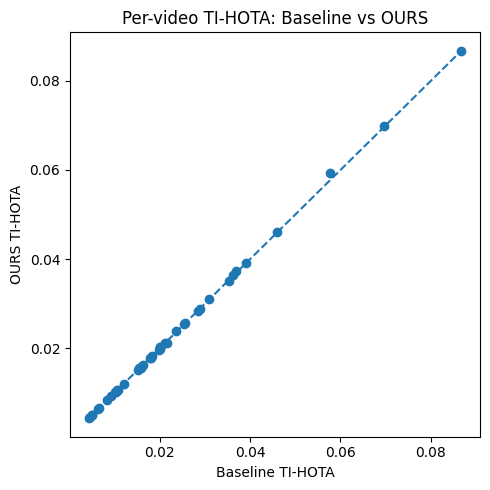

In [21]:
import numpy as np
import matplotlib.pyplot as plt

baseline_dict = baseline_results   # dict: name -> metrics
ours_dict     = ours_results       # dict: name -> metrics

common_names = sorted(set(baseline_dict.keys()) & set(ours_dict.keys()))

base_hota = [baseline_dict[n]["TI-HOTA"] for n in common_names]
ours_hota = [ours_dict[n]["TI-HOTA"]     for n in common_names]

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(base_hota, ours_hota)

min_val = min(base_hota + ours_hota)
max_val = max(base_hota + ours_hota)
ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

ax.set_xlabel("Baseline TI-HOTA")
ax.set_ylabel("OURS TI-HOTA")
ax.set_title("Per-video TI-HOTA: Baseline vs OURS")

plt.tight_layout()
plt.show()
